In [1]:
!pip install torch torchvision timm umap-learn

  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached numba-0.61.2-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.8 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
  Using cached llvmlite-0.44.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 11.2 MB/s eta 0:00:0000:01
Using cached umap_learn-0.5.7-py3-none-any.whl (88 kB)
Using cached numba-0.61.2-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.8 MB)
Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)
Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (471 kB)
Using cached llvmlite-0.44.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (42.4 MB)

[notice] A new release of pip is available: 25.0.1 -> 25.1
[

In [6]:
!pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 11.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [8]:
pip install tqdm


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import timm
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
import umap
import matplotlib.pyplot as plt

/home/aj3246/TRITON/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load DINOv2 ViT-small (pretrained)
dino_model = timm.create_model('vit_small_patch16_224.dino', pretrained=True)
dino_model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dino_model = dino_model.to(device)




Model loaded and moved to device: cuda


In [5]:
print("Model loaded and moved to device:", device)

Model loaded and moved to device: cuda


In [4]:
from tqdm import tqdm
# Transformation for DINOv2

# Faster DINOv2 Transformation without PIL
dino_transform = transforms.Compose([
    transforms.ToTensor(),  # Direct from numpy (uint8) to tensor [0,1]
    transforms.Resize((224, 224), antialias=True),
    transforms.ConvertImageDtype(torch.float32),  # Ensure float32
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


# Feature extraction function
def extract_features_dino(images_np, batch_size=64):
    features = []
    num_images = len(images_np)
    
    for i in tqdm(range(0, num_images, batch_size), desc="Extracting features"):
        batch_images = images_np[i:i+batch_size]
        batch_tensors = []

        for img_np in batch_images:
            img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
            img_tensor = img_tensor.float() / 255.0  # Scale 0-1
            img_tensor = torch.nn.functional.interpolate(img_tensor.unsqueeze(0), size=(224,224), mode='bilinear', align_corners=False)
            img_tensor = img_tensor.squeeze(0)
            img_tensor = (img_tensor - 0.5) / 0.5  # Normalize to mean=0, std=1
            batch_tensors.append(img_tensor)

        batch_tensors = torch.stack(batch_tensors).to(device)  # (batch_size, 3, 224, 224)

        with torch.no_grad():
            feats = dino_model.forward_features(batch_tensors)[:, 0]  # Take only CLS token

        features.append(feats.cpu().numpy())

    features = np.concatenate(features, axis=0)
    return features



In [5]:
import cv2
import os
import numpy as np

def load_images_cv2(folder_path, resize_shape=(32, 32)):
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)  # BGR format
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, resize_shape)
            image_list.append(img)
    return np.array(image_list)

# Usage
images_folder = '/home/aj3246/TRITON/material/material_data/1'
images_np = load_images_cv2(images_folder, resize_shape=(32, 32))

print(f"✅ Loaded {len(images_np)} images, shape: {images_np.shape}")


✅ Loaded 4295 images, shape: (4295, 32, 32, 3)


In [6]:
features = extract_features_dino(images_np)
print(features.shape)  # Should be (num_images, 384)


Extracting features: 100%|██████████| 68/68 [03:19<00:00,  2.93s/it]

(4295, 384)


In [10]:
# Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings = reducer.fit_transform(features)

print(embeddings.shape)  # (num_images, 2)


/home/aj3246/TRITON/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/aj3246/TRITON/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(4295, 2)


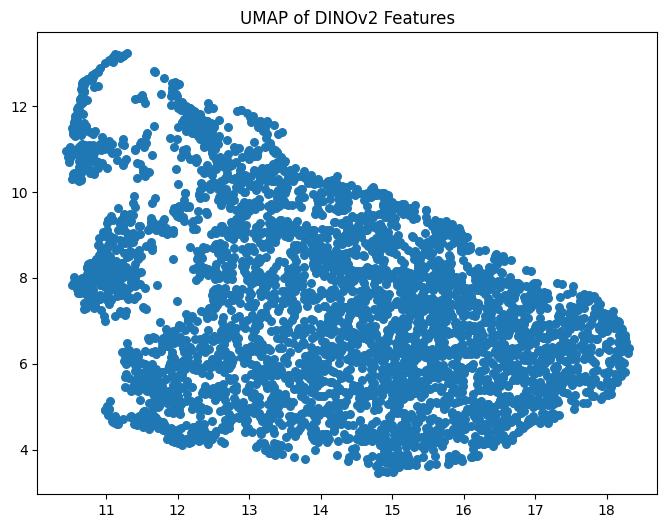

In [26]:
plt.figure(figsize=(8,6))
plt.scatter(embeddings[:,0], embeddings[:,1], s=30)
plt.title('UMAP of DINOv2 Features')
plt.show()

/home/aj3246/TRITON/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/aj3246/TRITON/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/aj3246/TRITON/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


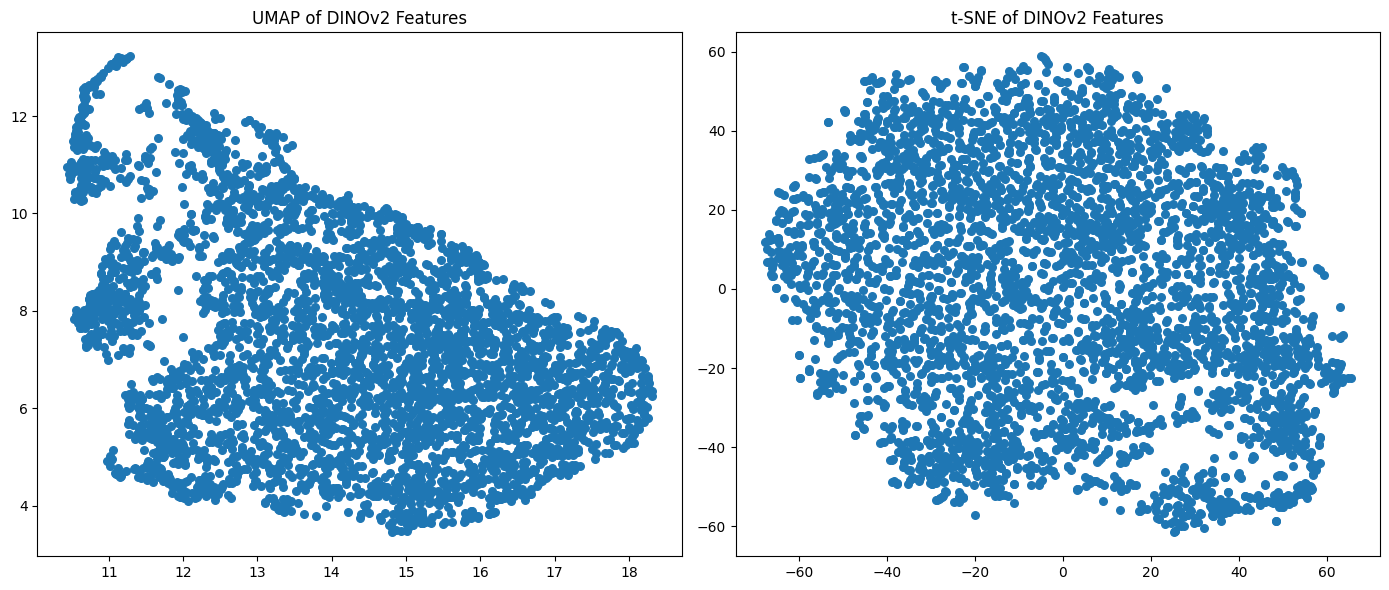

In [7]:
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'features' is your (N, D) matrix of image features

# Apply UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(features)

# Apply t-SNE
tsne_reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features) - 1), n_iter=1000, learning_rate=200)
tsne_embeddings = tsne_reducer.fit_transform(features)

# Plot side by side
plt.figure(figsize=(14, 6))

# UMAP plot
plt.subplot(1, 2, 1)
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=30)
plt.title('UMAP of DINOv2 Features')

# t-SNE plot
plt.subplot(1, 2, 2)
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=30)
plt.title('t-SNE of DINOv2 Features')

plt.tight_layout()
plt.show()


In [11]:
import torch

# Script the DINOv2 feature extractor
class DinoFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(DinoFeatureExtractor, self).__init__()
        self.backbone = model

    def forward(self, x):
        x = self.backbone.forward_features(x)  # Get all tokens
        x = x[:, 0]  # Take only CLS token
        return x  # Output shape (batch_size, 384)

# Wrap the model
feature_extractor = DinoFeatureExtractor(dino_model).to('cpu')  # Move to CPU for scripting

# Save as TorchScript
scripted_model = torch.jit.script(feature_extractor)
os.makedirs("dino_model/1", exist_ok=True)
scripted_model.save("dino_model/1/model.pt")

print("✅ Saved model to dino_model/1/model.pt")


✅ Saved model to dino_model/1/model.pt


In [12]:
loaded_model = torch.jit.load("dino_model/1/model.pt")
loaded_model.eval()

# Dummy input (batch of 2 images)
dummy_input = torch.randn(2, 3, 224, 224)  # Random normalized images
output = loaded_model(dummy_input)

print(output.shape)  # Should be (2, 384)
print(output)

torch.Size([2, 384])
tensor([[-4.5312e-01,  4.2606e+00,  3.8731e+00,  3.0325e+00,  4.6459e+00,
          3.9758e-01,  2.0155e+00, -6.1929e+00,  1.4768e-01, -1.1324e+00,
          2.6680e+00,  1.7563e+00, -5.9210e-01,  2.6389e+00,  4.2025e+00,
         -1.9141e+00, -1.0619e+00,  3.8621e+00, -7.8619e-01,  5.7385e+00,
          4.4503e+00,  9.1155e-01, -2.2616e+00,  4.2799e-01,  6.1353e+00,
         -8.0313e+00,  2.1035e+00,  6.9537e+00,  2.2623e-01, -1.2859e+00,
         -9.1714e+00, -6.3343e-01,  4.8045e+00, -2.4371e-01,  1.1984e+00,
          1.8055e+00,  4.3401e+00,  1.8364e-01, -5.6501e+00,  4.8747e+00,
          4.3270e+00,  3.8891e+00, -5.0887e+00,  3.1894e+00,  1.7894e+00,
         -2.0224e+00, -3.3469e+00, -1.4474e+00,  1.1840e+01, -5.4967e+00,
         -5.5850e+00,  3.0619e+00, -1.0941e+00, -2.3293e+00,  1.6631e+00,
         -2.0059e+00,  2.2990e+00,  1.0111e+01, -1.3198e+00, -3.0014e+00,
          1.7773e+00, -1.8893e+00, -1.7542e+00, -5.1122e+00, -2.1741e+00,
          4.7240e

In [13]:
print(loaded_model.graph)

graph(%self.1 : __torch__.DinoFeatureExtractor,
      %x.1 : Tensor):
  %9 : NoneType = prim::Constant()
  %13 : int = prim::Constant[value=1]() # /tmp/ipykernel_587973/3552681436.py:11:12
  %14 : int = prim::Constant[value=0]() # /tmp/ipykernel_587973/3552681436.py:11:17
  %backbone.1 : __torch__.timm.models.vision_transformer.VisionTransformer = prim::GetAttr[name="backbone"](%self.1)
  %x0.1 : Tensor = prim::CallMethod[name="forward_features"](%backbone.1, %x.1) # /tmp/ipykernel_587973/3552681436.py:10:12
  %12 : Tensor = aten::slice(%x0.1, %14, %9, %9, %13) # /tmp/ipykernel_587973/3552681436.py:11:12
  %15 : Tensor = aten::select(%12, %13, %14) # /tmp/ipykernel_587973/3552681436.py:11:12
  return (%15)



In [2]:
import numpy
print(numpy.__version__)

1.26.4


In [2]:
import torch
import timm
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
import umap
import matplotlib.pyplot as plt

/home/aj3246/TRITON/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
import torchvision.models as models

# Load pretrained ResNet-50
resnet_model = models.resnet50(pretrained=True)
resnet_model.eval()

# Remove the classification head (keep up to the penultimate layer)
resnet_feature_extractor = torch.nn.Sequential(*list(resnet_model.children())[:-1])  # Output shape: (batch_size, 2048, 1, 1)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Model loaded and moved to device:", device)
resnet_feature_extractor = resnet_feature_extractor.to(device)
print("ResNet-50 model loaded and moved to device:", device)


/home/aj3246/TRITON/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aj3246/TRITON/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded and moved to device: cuda
ResNet-50 model loaded and moved to device: cuda


In [26]:
from tqdm import tqdm
def extract_features_resnet(images_np, batch_size=256):
    features = []
    num_images = len(images_np)
    
    for i in tqdm(range(0, num_images, batch_size), desc="Extracting features (ResNet)"):
        batch_images = images_np[i:i+batch_size]
        batch_tensors = []

        for img_np in batch_images:
            img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).float() / 255.0  # (C, H, W)
            img_tensor = torch.nn.functional.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
            img_tensor = img_tensor.squeeze(0)
            img_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])(img_tensor)
            batch_tensors.append(img_tensor)

        batch_tensors = torch.stack(batch_tensors).to(device)

        with torch.no_grad():
            feats = resnet_feature_extractor(batch_tensors)  # (B, 2048, 1, 1)
            feats = feats.squeeze(-1).squeeze(-1)  # (B, 2048)

        features.append(feats.cpu().numpy())

    features = np.concatenate(features, axis=0)
    return features


In [17]:
import cv2
import os
import numpy as np

def load_images_cv2(folder_path, resize_shape=(224, 224)):
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)  # BGR format
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, resize_shape)
            image_list.append(img)
    return np.array(image_list)

# Usage
images_folder = '/home/aj3246/TRITON/material/material_data/1'
images_np = load_images_cv2(images_folder, resize_shape=(224, 224))

print(f"✅ Loaded {len(images_np)} images, shape: {images_np.shape}")


✅ Loaded 4295 images, shape: (4295, 224, 224, 3)


In [27]:
features = extract_features_resnet(images_np)
print(features.shape)  # (num_images, 2048)


Extracting features (ResNet): 100%|██████████| 17/17 [05:40<00:00, 20.03s/it]

(4295, 2048)


/home/aj3246/TRITON/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/aj3246/TRITON/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/aj3246/TRITON/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


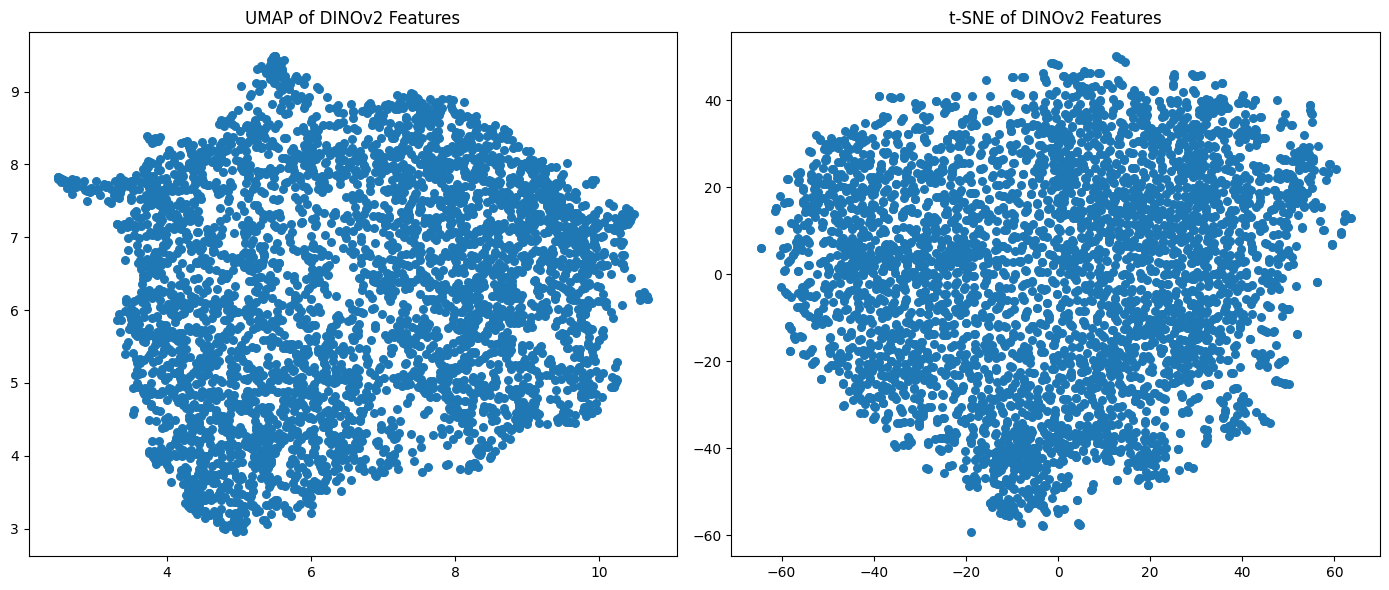

In [28]:
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'features' is your (N, D) matrix of image features

# Apply UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(features)

# Apply t-SNE
tsne_reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features) - 1), n_iter=1000, learning_rate=200)
tsne_embeddings = tsne_reducer.fit_transform(features)

# Plot side by side
plt.figure(figsize=(14, 6))

# UMAP plot
plt.subplot(1, 2, 1)
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=30)
plt.title('UMAP of DINOv2 Features')

# t-SNE plot
plt.subplot(1, 2, 2)
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=30)
plt.title('t-SNE of DINOv2 Features')

plt.tight_layout()
plt.show()


In [21]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from torchvision.models import resnet50
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet50 model without classification head
resnet_model = resnet50(pretrained=True)
resnet_feature_extractor = torch.nn.Sequential(*list(resnet_model.children())[:-1])  # (B, 2048, 1, 1)
resnet_feature_extractor = resnet_feature_extractor.to(device)

# Dataset
class ResNetImageDataset(Dataset):
    def __init__(self, folder_path):
        self.image_paths = [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        self.transform = Compose([
            Resize((224, 224)),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406],
                      std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(image)

# Feature extractor
def extract_features_resnet_from_paths(folder_path, batch_size=256, num_workers=4):
    dataset = ResNetImageDataset(folder_path)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True)

    features = []
    resnet_feature_extractor.eval()

    with torch.no_grad():
        for batch in tqdm(loader, desc="Extracting features (ResNet)"):
            batch = batch.to(device, non_blocking=True)
            feats = resnet_feature_extractor(batch).squeeze(-1).squeeze(-1)  # (B, 2048)
            features.append(feats.cpu().numpy())

    return np.concatenate(features, axis=0)

# Run
images_folder = '/home/aj3246/TRITON/material/material_data/1'
features = extract_features_resnet_from_paths(images_folder)
print("✅ ResNet Features shape:", features.shape)


/home/aj3246/TRITON/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aj3246/TRITON/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features (ResNet): 100%|██████████| 17/17 [00:04<00:00,  3.57it/s]

✅ ResNet Features shape: (4295, 2048)


In [22]:
# Load DINOv2 ViT-small (pretrained)
dino_model = timm.create_model('vit_small_patch16_224.dino', pretrained=True)
dino_model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dino_model = dino_model.to(device)




In [23]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from tqdm import tqdm

class DinoImageDataset(Dataset):
    def __init__(self, folder_path):
        self.image_paths = [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        self.transform = Compose([
            Resize((224, 224)),
            ToTensor(),  # Converts to [0,1] and CHW
            Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Same as your manual normalization
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(image)

def extract_features_dino_from_paths(folder_path, batch_size=264, num_workers=4):
    dataset = DinoImageDataset(folder_path)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True)

    features = []
    dino_model.eval()

    with torch.no_grad():
        for batch in tqdm(loader, desc="Extracting features (DINOv2)"):
            batch = batch.to(device, non_blocking=True)
            feats = dino_model.forward_features(batch)[:, 0]  # CLS token
            features.append(feats.cpu().numpy())

    return np.concatenate(features, axis=0)


images_folder = '/home/aj3246/TRITON/material/material_data/1'
features = extract_features_dino_from_paths(images_folder)
print("✅ DINO Features shape:", features.shape)


Extracting features (DINOv2): 100%|██████████| 17/17 [00:04<00:00,  3.53it/s]

✅ DINO Features shape: (4295, 384)


In [9]:
import torch.nn as nn

class DinoCLSExtractor(nn.Module):
    def __init__(self, dino_model):
        super().__init__()
        self.dino = dino_model

    def forward(self, x):
        # Output shape: (B, 384)
        return self.dino.forward_features(x)[:, 0]

dummy_input = torch.randn(1, 3, 224, 224).to(device)  # match real input

model = DinoCLSExtractor(dino_model).to(device)
model.eval()

torch.onnx.export(
    model,
    dummy_input,
    "model.onnx",
    input_names=["INPUT__0"],
    output_names=["OUTPUT__0"],
    dynamic_axes={
        "INPUT__0": {0: "batch_size"},
        "OUTPUT__0": {0: "batch_size"}
    },
    opset_version=17
)

print("✅ DINO ONNX exported successfully.")


/home/aj3246/TRITON/.venv/lib/python3.10/site-packages/torch/__init__.py:2150: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


✅ DINO ONNX exported successfully.


import tritonclient.http as httpclient
import numpy as np

# Dummy batch of shape (128, 3, 224, 224)
dummy_input = np.random.rand(128, 3, 224, 224).astype(np.float32)

client = httpclient.InferenceServerClient("localhost:8000")

input_tensor = httpclient.InferInput("INPUT__0", dummy_input.shape, "FP32")
input_tensor.set_data_from_numpy(dummy_input)

output_tensor = httpclient.InferRequestedOutput("OUTPUT__0")

response = client.infer(model_name="dino_model_onnx", inputs=[input_tensor], outputs=[output_tensor])

features = response.as_numpy("OUTPUT__0")
print("✅ Output shape:", features.shape)


In [24]:
import tritonclient.http as httpclient
import numpy as np

# Dummy batch of shape (128, 3, 224, 224)
dummy_input = np.random.rand(128, 3, 224, 224).astype(np.float32)

client = httpclient.InferenceServerClient("localhost:8000")

input_tensor = httpclient.InferInput("INPUT__0", dummy_input.shape, "FP32")
input_tensor.set_data_from_numpy(dummy_input)

output_tensor = httpclient.InferRequestedOutput("OUTPUT__0")

response = client.infer(model_name="dino_model_onnx", inputs=[input_tensor], outputs=[output_tensor])

features = response.as_numpy("OUTPUT__0")
print("✅ Output shape:", features.shape)


✅ Output shape: (128, 384)
